# Abusing PCA as a generative model

Here we deliberately *misuse* PCA as a generative model:
we encode images (**X → Z**), sample in latent space, and decode back (**Z → X′**).

This works technically – but the probability model is *glued on afterwards* (KDE).  
PCA itself is **not** generative.

### Loading the MNIST dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def load_mnist():
    # Preferred: Keras MNIST
    try:
        from tensorflow.keras.datasets import mnist
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        x = np.concatenate([x_train, x_test], axis=0)
        y = np.concatenate([y_train, y_test], axis=0)
        return x, y
    except Exception as e_keras:
        # Fallback: torchvision
        try:
            import torch
            from torchvision.datasets import MNIST
            from torchvision.transforms import ToTensor

            ds = MNIST(root="./data", train=True, download=True, transform=ToTensor())
            x = ds.data.numpy()  # (60000, 28, 28)
            y = ds.targets.numpy()
            return x, y
        except Exception as e_tv:
            raise RuntimeError(
                "Could not load MNIST. Install either tensorflow or torchvision.\n"
                f"Keras error: {e_keras}\nTorchvision error: {e_tv}"
            )

rng = np.random.default_rng(0)

x, y = load_mnist()  # x: (N, 28, 28), y: (N,)
N = len(x)

n_samples = 5000
idx = rng.permutation(N)[:n_samples]
x_sub = x[idx].astype(np.float32)
y_sub = y[idx].astype(int)

# Flatten + normalize
X = x_sub.reshape(n_samples, -1) / 255.0

print("X:", X.shape, "y:", y_sub.shape)

X: (5000, 784) y: (5000,)


### Doing the PCA

Note that the labels are not used in the PCA, but they are used to color the points in the latent space.

Explained variance ratio: [0.09850237 0.07089241]
Total explained (2D): 0.16939478


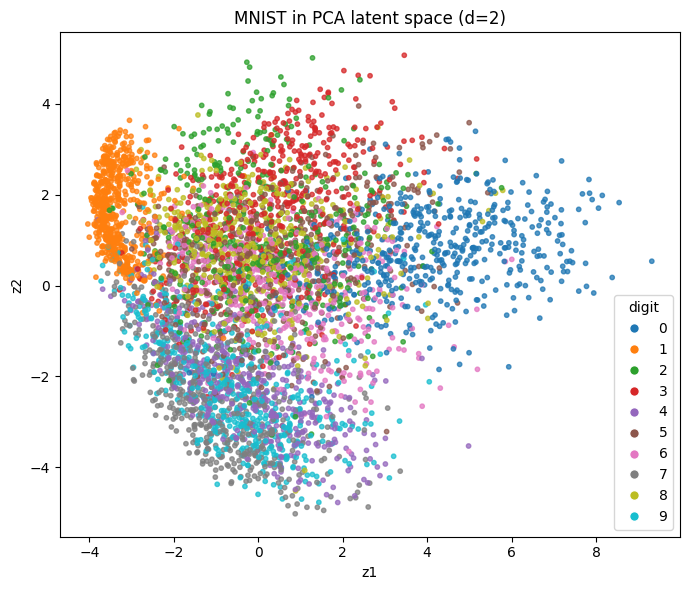

In [4]:
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained (2D):", pca.explained_variance_ratio_.sum())

# Discrete colormap for digits 0..9
cmap10 = ListedColormap([plt.get_cmap("tab10")(i) for i in range(10)])

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(Z[:, 0], Z[:, 1], c=y_sub, cmap=cmap10, s=10, alpha=0.75)
ax.set_title("MNIST in PCA latent space (d=2)")
ax.set_xlabel("z1"); ax.set_ylabel("z2")

# Discrete legend instead of colorbar
handles = [
    plt.Line2D([0], [0], marker='o', linestyle='', color='w',
               markerfacecolor=cmap10(d), markersize=7)
    for d in range(10)
]
ax.legend(handles, [str(d) for d in range(10)], title="digit", loc="best", frameon=True)

plt.tight_layout()
plt.show()

### PCA reconstruction demo (X → Z → X′)
The PCA can be understood as a deterministic compression method, minimizing the reconstruction error $||X - X'||^2$ between the original image $X$ and the reconstructed image $X'$. To demonstrate this:

We randomly select four MNIST images **X**,  
encode them with PCA to obtain their latent representations **Z**,  
and decode them back using the inverse PCA transform to get **X′**.

This visualizes:
- where the images lie in latent space
- how much information is lost in the 2D compression
- how well PCA can reconstruct the originals

This illustrates the pipeline:

**X → Z → X′**

and highlights that PCA is a *deterministic* compression method,  
not a probabilistic generative model.

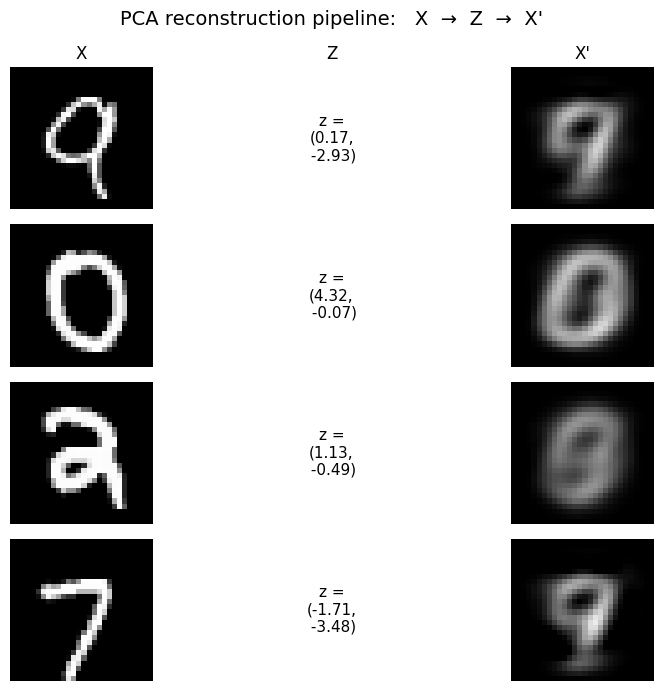

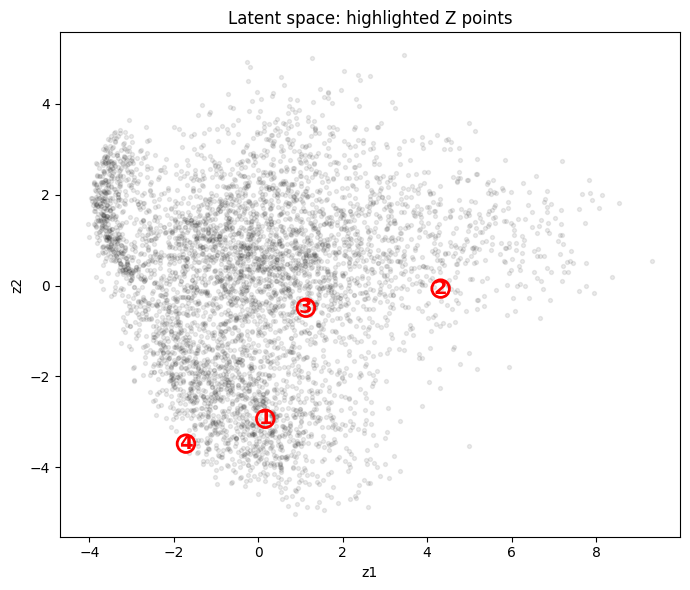

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ---- choose 4 indices ----
rng = np.random.default_rng(1)
idx4 = rng.choice(len(X), size=4, replace=False)

# originals and latent positions
X0 = x_sub[idx4].astype(np.float32) / 255.0   # (4,28,28)
Z0 = Z[idx4]                                  # (4,2)

# reconstruct via PCA
Xrec_flat = pca.inverse_transform(Z0)
Xrec = np.clip(Xrec_flat.reshape(-1, 28, 28), 0.0, 1.0)

# ---- layout: rows = samples, cols = X | Z | X' ----
fig = plt.figure(figsize=(9, 7))
gs = fig.add_gridspec(4, 3, width_ratios=[1, 0.6, 1])

for i in range(4):

    # ---- column 1: X ----
    ax = fig.add_subplot(gs[i, 0])
    ax.imshow(X0[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title("X" if i == 0 else "")
    ax.axis("off")

    # ---- column 2: Z (textual representation) ----
    ax = fig.add_subplot(gs[i, 1])
    ax.text(0.5, 0.5,
            f"z =\n({Z0[i,0]:.2f},\n {Z0[i,1]:.2f})",
            ha="center", va="center", fontsize=11)
    ax.set_title("Z" if i == 0 else "")
    ax.axis("off")

    # ---- column 3: X' ----
    ax = fig.add_subplot(gs[i, 2])
    ax.imshow(Xrec[i], cmap="gray", vmin=0, vmax=1)
    ax.set_title("X'" if i == 0 else "")
    ax.axis("off")

fig.suptitle("PCA reconstruction pipeline:   X  →  Z  →  X'", fontsize=14)
plt.tight_layout()
plt.show()


# ---- latent plot: mark Z positions ----
fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(Z[:, 0], Z[:, 1], c="k", s=8, alpha=0.08)

ax.scatter(Z0[:, 0], Z0[:, 1],
           s=160, facecolors="none",
           edgecolors="red", linewidths=2)

for j in range(4):
    ax.text(Z0[j, 0], Z0[j, 1], str(j+1),
            color="red", fontsize=14,
            ha="center", va="center", fontweight="bold")

ax.set_title("Latent space: highlighted Z points")
ax.set_xlabel("z1"); ax.set_ylabel("z2")
plt.tight_layout()
plt.show()

### Hacking a density estimate on the latent space

PCA is not a probabilistic method per se, but with post-hoc construct a density $p(z)$ on the latent space using a kernel density estimate of the training data. This is like counting the number of training points in each latent space cell. Details of the KDE are unimportant here.

Best KDE bandwidth: 0.3


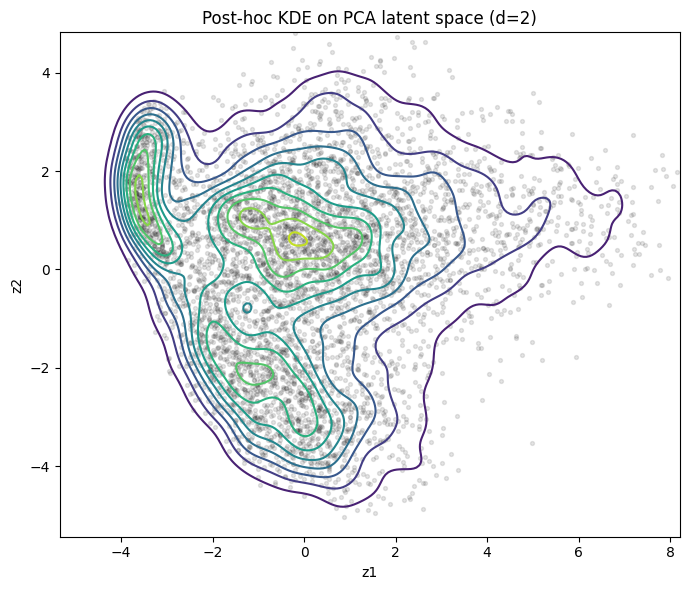

In [9]:
 # KDE bandwidth selection (works well for this demo)
bandwidth_grid = [0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1.2]
kde_cv = GridSearchCV(KernelDensity(kernel="gaussian"), {"bandwidth": bandwidth_grid}, cv=3, n_jobs=-1)
kde_cv.fit(Z)
kde = kde_cv.best_estimator_
print("Best KDE bandwidth:", kde.bandwidth)

def plot_kde_contours(ax, kde, Z_ref, grid_n=220, n_levels=12):
    z1_min, z1_max = np.percentile(Z_ref[:, 0], [1, 99])
    z2_min, z2_max = np.percentile(Z_ref[:, 1], [1, 99])
    pad1 = 0.15 * (z1_max - z1_min)
    pad2 = 0.15 * (z2_max - z2_min)
    z1_min -= pad1; z1_max += pad1
    z2_min -= pad2; z2_max += pad2

    z1 = np.linspace(z1_min, z1_max, grid_n)
    z2 = np.linspace(z2_min, z2_max, grid_n)
    Z1, Z2 = np.meshgrid(z1, z2)
    grid = np.column_stack([Z1.ravel(), Z2.ravel()])

    dens = np.exp(kde.score_samples(grid)).reshape(grid_n, grid_n)
    ax.contour(Z1, Z2, dens, levels=n_levels)
    ax.set_xlim(z1_min, z1_max)
    ax.set_ylim(z2_min, z2_max)

fig, ax = plt.subplots(figsize=(7, 6))
ax.scatter(Z[:, 0], Z[:, 1], c="k", s=8, alpha=0.10)  # background
plot_kde_contours(ax, kde, Z_ref=Z, grid_n=220, n_levels=12)

ax.set_title("Post-hoc KDE on PCA latent space (d=2)")
ax.set_xlabel("z1"); ax.set_ylabel("z2")
plt.tight_layout()
plt.show()

### Sampling from the PCA
Randomly sample points from the latent space and decode them back to images.

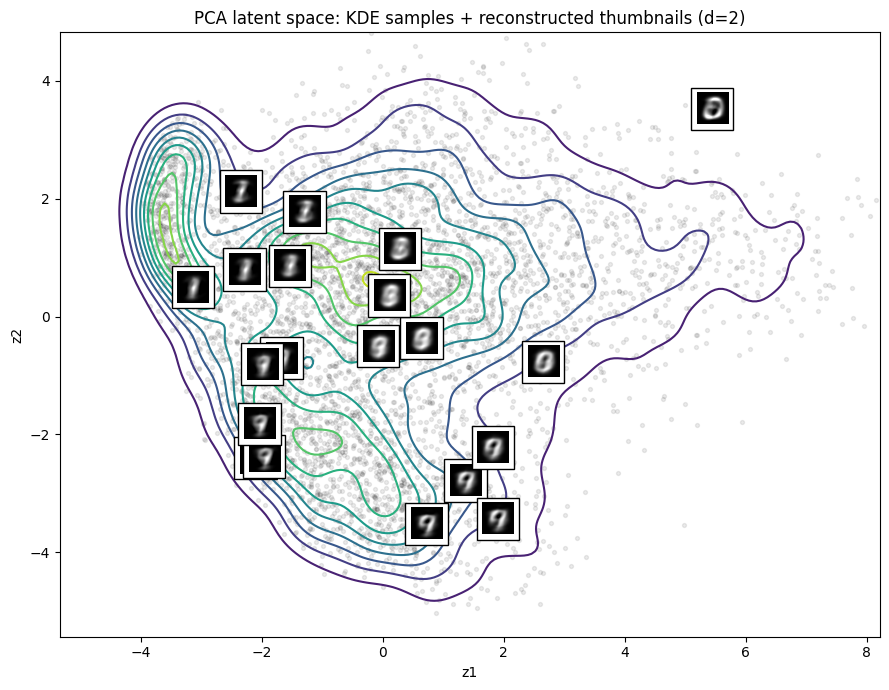

In [12]:
n_samp = 20
Z_kde = kde.sample(n_samples=n_samp, random_state=0)

# Decode: PCA inverse transform -> images
X_kde = pca.inverse_transform(Z_kde)              # (20, 784)
imgs_kde = np.clip(X_kde.reshape(-1, 28, 28), 0.0, 1.0)

def add_thumbnails(ax, Z_pts, imgs, zoom=0.75):
    for (zx, zy), im in zip(Z_pts, imgs):
        oi = OffsetImage(im, cmap="gray", zoom=zoom)
        ab = AnnotationBbox(
            oi, (zx, zy),
            frameon=True,
            bboxprops=dict(linewidth=1)
        )
        ax.add_artist(ab)

fig, ax = plt.subplots(figsize=(9, 7))
ax.scatter(Z[:, 0], Z[:, 1], c="k", s=8, alpha=0.08)
plot_kde_contours(ax, kde, Z_ref=Z, grid_n=220, n_levels=12)

# show sampled points (optional visual anchor)
ax.scatter(Z_kde[:, 0], Z_kde[:, 1], s=50, alpha=0.9, edgecolors="white", linewidths=0.7)

# thumbnails at their latent positions
add_thumbnails(ax, Z_kde, imgs_kde, zoom=0.8)

ax.set_title("PCA latent space: KDE samples + reconstructed thumbnails (d=2)")
ax.set_xlabel("z1"); ax.set_ylabel("z2")
plt.tight_layout()
plt.show()